# Visualization of DNA movement in dividing Sufolobus

In this notebook, we load the h5 file containing the results and generate individual visualization.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setup the path to the destination folder

In [ ]:
from pathlib import Path
import dnasufo as mq
import matplotlib.pyplot as plt

# define the path to the result folder
dst = Path('/media/cephfs2/jeromeb/userdata/Baum_group/jparham/Analysis8')

List all the files in the destination folder

In [ ]:
items = mq.inspect_result(dst)
print(f"There are {len(items)} items in '{dst}'.")

/home/jeromeb/micromamba/envs/imaging/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


There are 240 items in '/media/cephfs2/jeromeb/userdata/Baum_group/jparham/Analysis8'.


Make a figure for a selected a sequences.

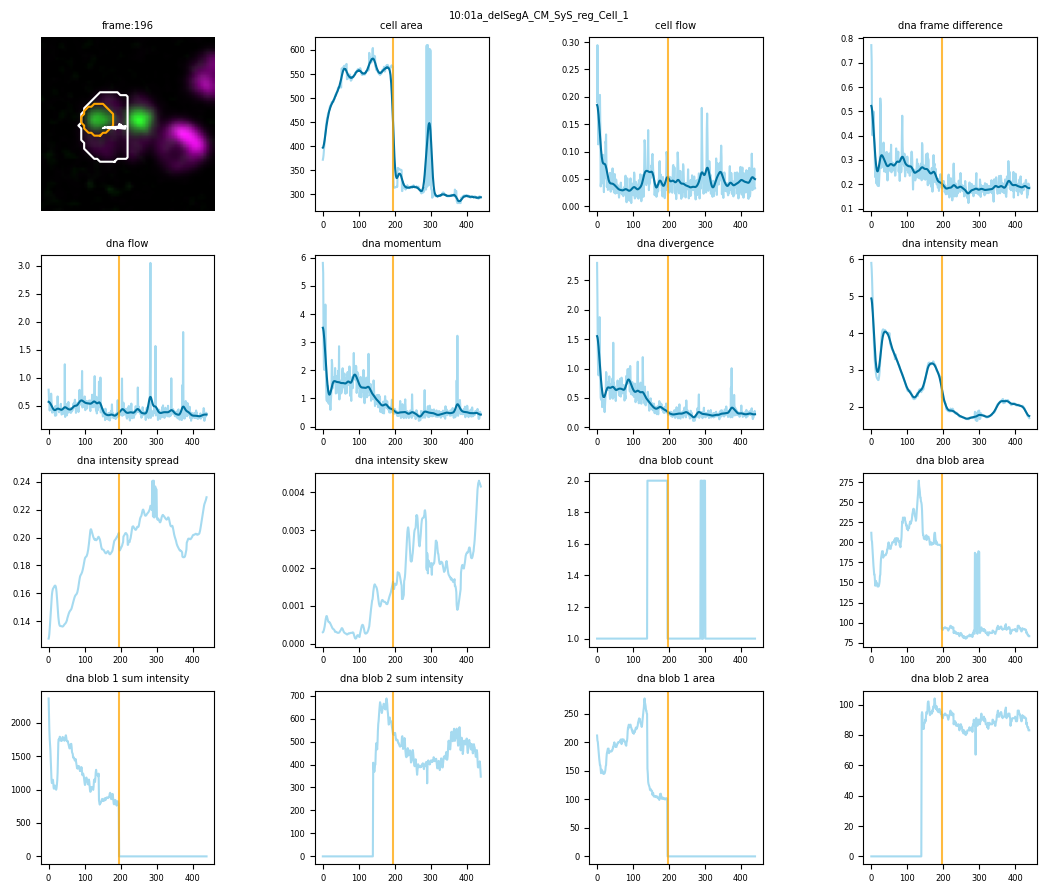

In [10]:
plt.rc('font', size=6)
mq.figure(dst, 10, frame="auto")

Save all figures in a multipage pdf

In [27]:
from matplotlib.backends.backend_pdf import PdfPages

plt.rc('font', size=6)
with PdfPages(dst / f'figures.pdf') as pdf:
    for index in items:
        plt.clf()
        mq.figure(dst, index, frame="auto")
        pdf.savefig()
        plt.close()

<Figure size 640x480 with 0 Axes>

Inspect a single strip

In [ ]:

import numpy as np

mq.strip(dst, 0, "Greys", selection="auto", quiver=False)




Save all strips as individual pdf files

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

plt.rc('font', size=6)
with PdfPages(dst / 'strips.pdf') as pdf:
    for index in items:
        plt.clf()
        mq.strip(dst, index, "Greys", selection="auto", quiver=False)
        pdf.savefig()
        plt.close()

/home/jeromeb/work/code/baum/dna-movement-sufolobus/motionquant.py:19: RuntimeWarning: invalid value encountered in divide
  return (x - x.min()) / (x.max() - x.min())


<Figure size 640x480 with 0 Axes>

Visualize the image and mask using napari

In [40]:
# import napari
# import numpy as np
# img, cell_mask, cell_trj, diff, flow, rho, div, blob_labels, blob_trj = mq.load_result(
#     filename, name
# )
# vector = mq.make_vector(rho,4)
# v = napari.view_image(img, channel_axis=1)
# v.add_labels(cell_mask.squeeze().astype(np.uint64))
# v.add_vectors(vector, edge_width=0.1, edge_color="white", length=1)

<Vectors layer 'vector' at 0x73e6e126e610>

### Export to excel

In [3]:
import pandas as pd

# load and concatenate all the csv files
df = pd.concat([pd.read_csv(x) for x in dst.glob('*.csv')])

# df = pd.read_csv(dst/'results.csv',index_col=0)

Add a synchronized time

In [4]:
ndf = []
for k, ng in enumerate(df.groupby('filename')):
    name, group = ng
    t0 = mq.split_frame(group)    
    group['sync frame'] = group['frame'] - t0
    ndf.append(group)
df = pd.concat(ndf)

Add the condition

In [6]:
filelist = pd.read_csv('filelist.csv',usecols=['name','condition'])
filelist['filename'] = filelist['name'].apply(lambda x:Path(x).stem)
dfc = df.merge(filelist.drop('name',axis=1),on='filename',how='left')
dfc.to_csv(dst/'results_with_condition.csv')

Save all results to a excel file

In [24]:
with pd.ExcelWriter(dst/'sheets.xlsx') as writer:
    for tab in df.columns[6:]:
        tmp = df.pivot_table(values=tab, index='frame', columns='filename')
        tmp.to_excel(writer,sheet_name=tab)
        # smoothed version
        for c in tmp.columns:
            tmp[c] = mq.ndi.gaussian_filter1d(tmp[c], 5)
        tmp.to_excel(writer,sheet_name=f"{tab}-smoothed")

FileNotFoundError: [Errno 2] No such file or directory: '/media/cephfs2/jeromeb/userdata/Baum_group/jparham/Analysis8/sheets.xlsx'

In [35]:
pd.set_option('future.no_silent_downcasting', True)
with pd.ExcelWriter(dst/'sheet.xlsx') as writer:
    for n,g in df.groupby('filename'):
        for c in df.columns[7:-1]:
            g[f'{c} smoothed'] = mq.ndi.gaussian_filter1d(g[c].replace(pd.NA, 0.0).infer_objects(copy=False), 5)
        g.to_excel(writer, sheet_name=Path(n).stem)

/home/jeromeb/micromamba/envs/imaging/lib/python3.11/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/jeromeb/micromamba/envs/imaging/lib/python3.11/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/jeromeb/micromamba/envs/imaging/lib/python3.11/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/jeromeb/micromamba/envs/imaging/lib/python3.11/site-packages/openpyxl/workbook/child.py:99: Us

Display each measurement by condition

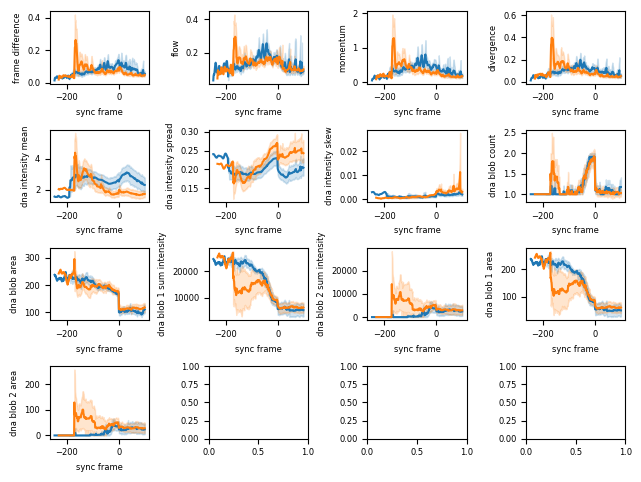

In [56]:
import seaborn as sns
import numpy as np
cols = dfc.columns[5:-2]
fig,ax = plt.subplots(4, int(np.ceil(len(cols)/4)))
ax = ax.ravel()
for k,c in enumerate(cols):    
    p = sns.lineplot(data=dfc[dfc["sync frame"]<100], x='sync frame', y=c, hue='condition', ax=ax[k])
    p.get_legend().remove()
fig.set_tight_layout(True)

Use seaborn to create a figure

In [ ]:
dflong = pd.melt(df.iloc[0:1200], id_vars=('filename','frame') , value_vars=df.columns[6:])
dflong.head()

In [ ]:
grid = sns.FacetGrid(data=dflong, row='filename', col='variable', sharey = False)
grid.map_dataframe(sns.lineplot, x="frame",y="value")
# grid.set_titles(template="", row_template='{row_var}{row_name}',col_template='{col_var}{col_name}')
grid.set_titles("", col_template='{col_name}')

In [ ]:
facet_kws={'sharey': False, 'sharex': True}
sns.relplot(data=dflong, x="frame", y="value", col="filename", row="variable", kind='line', facet_kws=facet_kws)